In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from pypots.data import masked_fill
from pypots.imputation import SAITS
from pypots.utils.metrics import cal_mae
import torch

In [2]:
df = pd.read_csv('../../data/merged/Merged_June23.csv', dtype=str)

In [3]:
# set variable types
df['ZipCode'] = df['ZipCode'].astype(str)
df['Date'] = pd.to_datetime(df['Date'])
df['ZHVI'] = df['ZHVI'].astype(float)
df['MedianSalePrice'] = df['MedianSalePrice'].astype(float)
df['MedianListPrice'] = df['MedianListPrice'].astype(float)
df['HomesSold'] = df['HomesSold'].astype(float)
df['NewListings'] = df['NewListings'].astype(float)
df['Inventory'] = df['Inventory'].astype(float)

## Visualizing missing values before imputation

In [4]:
# saits requires data to be sorted by primary and secondary index
# this is done again in the dataloader but for the sake of consistency we do it up front as well
df = df.sort_values(['ZipCode','Date'])
df = df.reset_index(drop=True)

In [5]:
# a list of zip codes and the total count of months with missing data in any covariate
na_list = df[(df.isna() == True).any(axis=1)].groupby('ZipCode')['Date'].count().sort_values()

In [6]:
# find proportion of zipcodes with any data missing
round(len(na_list) / df['ZipCode'].nunique(),4)

0.2385

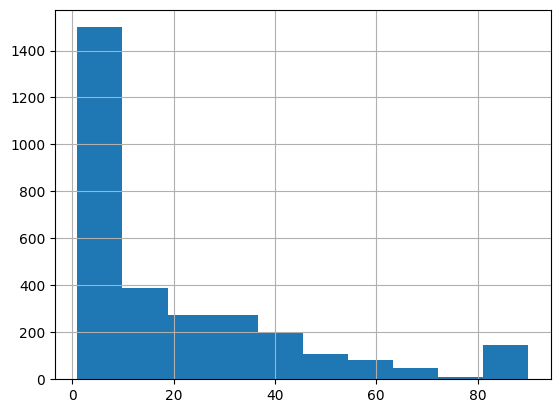

In [7]:
# here we see a spike at the tail because some zip codes have every value for inventory missing
na_list.sort_values().hist();

In [8]:
# count total amount of missing values by zip code
grouped_data = df.groupby('ZipCode')
missing_counts_per_group = grouped_data.apply(lambda x: x.isna().sum())
missing_counts_per_group = missing_counts_per_group.sum(axis=1)
missing_counts_per_group = missing_counts_per_group.sort_values()

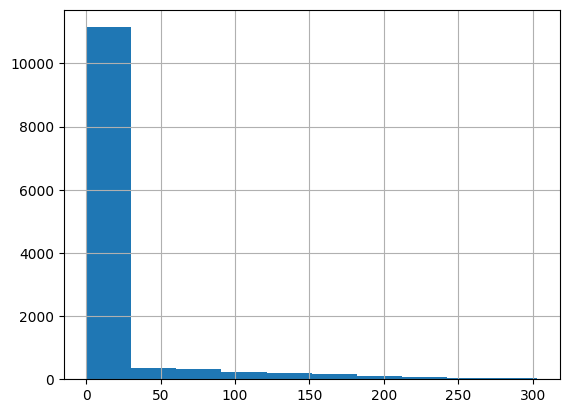

In [9]:
missing_counts_per_group.hist();

In [10]:
# a surprise tool we'll need later
# create 3 different groups of zip codes based on how many values they have missing so we can graph data for a consistent set of areas

few_missing_filter = missing_counts_per_group == 10 
few_missing = missing_counts_per_group[few_missing_filter].head(5)

some_missing_filter = missing_counts_per_group == 60 
some_missing = missing_counts_per_group[some_missing_filter].head(5)

most_missing = missing_counts_per_group.tail(5)

In [11]:
import matplotlib.pyplot as plt

def graph_data(df, zip, df_imputation=None):
    '''
    Parameters
    ----------

    df : DataFrame,
        This can be either the original df or the new df with imputed values
    
    zip : string,
        The zip code of the area to graph. These can come from the different lists of zip codes grouped by how many values they have missing

    df_imputation : DataFrame or None, optional
        If provided, this dataframe will be used for comparison in the second set of charts.

    Returns
    -------

    If only one df is provided:
        Two graphs: One with price data and another with housing supply/ volume data
    
    If orginal and imputed df are provided:
        Top two graphs: One for price and another for housing suppy/ volume data
        Bottom two graphs: The same two graphs as above except data has been imputed
        
    '''
    if df_imputation is not None:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes[0, 0].set_title('Original Price')
        axes[0, 1].set_title('Original Volume')
        axes[1, 0].set_title('Imputed Price')
        axes[1, 1].set_title('Imputed Volume')

        df[df['ZipCode'] == zip].set_index('Date')[['ZHVI','MedianSalePrice', 'MedianListPrice']].plot(ax=axes[0, 0])
        df[df['ZipCode'] == zip].set_index('Date')[['NewListings','Inventory', 'HomesSold']].plot(ax=axes[0, 1])

        df_imputation[df_imputation['ZipCode'] == zip].set_index('Date')[['ZHVI','MedianSalePrice', 'MedianListPrice']].plot(ax=axes[1, 0])
        df_imputation[df_imputation['ZipCode'] == zip].set_index('Date')[['NewListings','Inventory', 'HomesSold']].plot(ax=axes[1, 1])

    else:    
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].set_title('Prices')
        axes[1].set_title('Volume')

        df[df['ZipCode'] == zip].set_index('Date')[['ZHVI','MedianSalePrice', 'MedianListPrice']].plot(ax=axes[0]);
        df[df['ZipCode'] == zip].set_index('Date')[['NewListings','Inventory', 'HomesSold']].plot(ax=axes[1]);


    

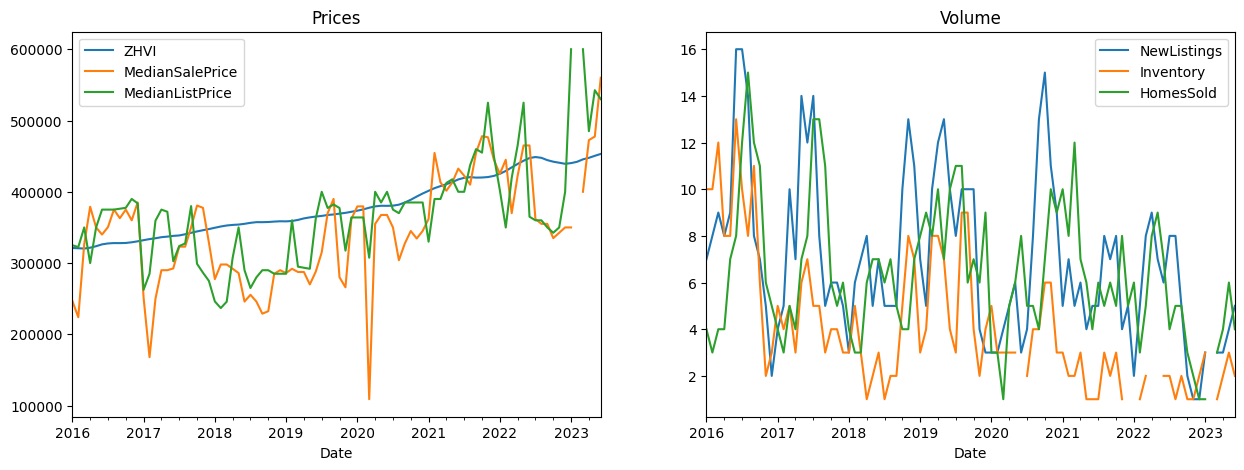

In [12]:
graph_data(df, few_missing.index[0])

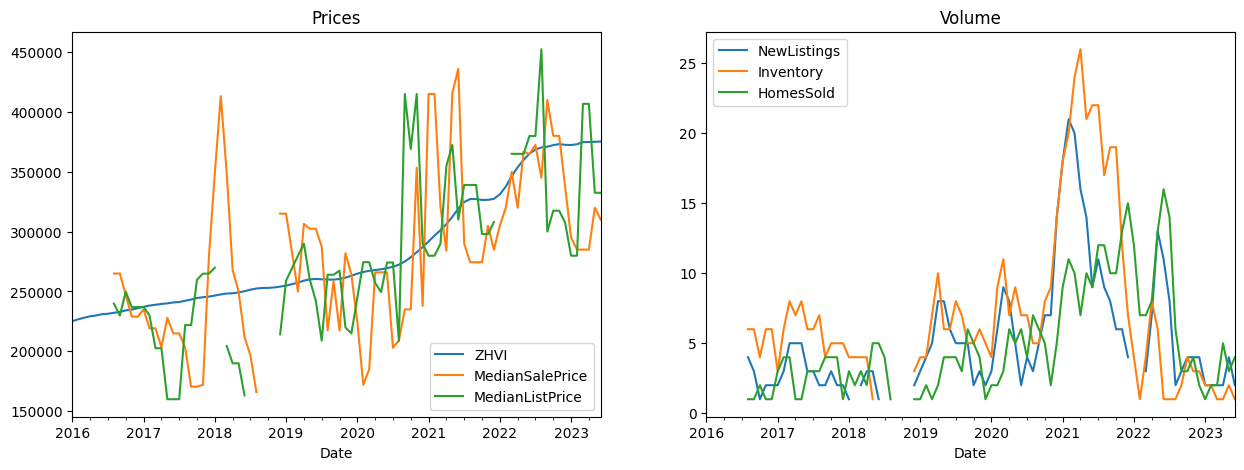

In [13]:
graph_data(df, some_missing.index[3])

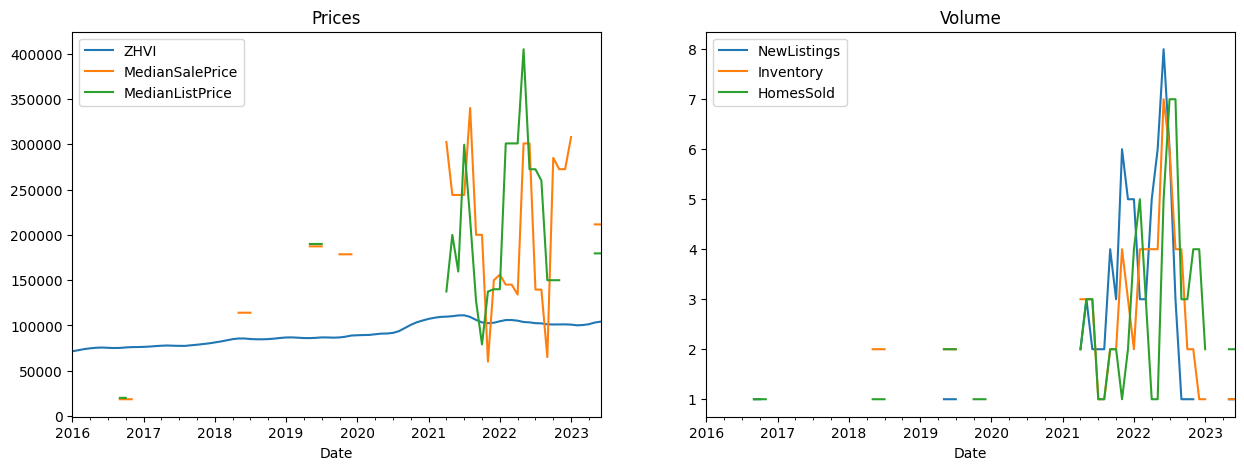

In [14]:
graph_data(df, most_missing.index[0])

## PyPOTS Custom Functions

In [15]:
def mnar_numpy(X, mcar_rate, conseq_rate, conseq_length, nan=0):
    """ Combine MCAR case with a MNAR case where there are consecutive missing values in certain covariates

    Missing completely at random (MCAR) randomly removes values from all covariates and assumes independence between the missing values and the observed values.

    Missing not at random (MNAR) removes consecutive values in certain covariates since there is a relationship between the missing values and the observed values.

    By combining these two cases, we can match roughly match what is actually observed in the data so that the model does a better job of learning from this data and the reported metrics are more accurate for this use case.

    Parameters
    ----------

    X : array,
        Data vector. If X has any missing values, they should be numpy.nan.

    mcar_rate : float, in (0,1),
        Artificially missing rate, rate of the observed values which will be artificially masked as missing for mcar.

        Note:
        `rate` = (number of artificially missing values) / np.sum(~np.isnan(self.data)),
        not (number of artificially missing values) / np.product(self.data.shape),
        considering that the given data may already contain missing values,
        the latter way may be confusing because if the original missing rate >= `rate`,
        the function wont actually introduce any new missing values.

    conseq_rate : float, in (0,1),
        Rate of groups that will have consecutive missing values artificially masked.

        Note:
        Rate will be (number of groups) / (number of groups without any missing values)

    conseq_length : int,
        Number of consecutive timeseries entries that will be artificially removed for each group.

    nan : int/float, optional, default=0
        Value used to fill NaN values.

    Returns
    -------

    Same format as mcar_numpy (default for PyPOTS) examples.

    """
    # helper function to convert 3d indices into 1d indices
    def _flatten_index(arr, i, j, k):
      shape = arr.shape
      return (i * shape[1] * shape[2]) + (j * shape[2]) + k


    # get index of each group that does not have any missing data
    arr_idx = []
    for i in range(len(X)):
      if np.isnan(X[i]).any() == False:
        arr_idx.append(i)

    # conseq_rate 
    # arr_idx will contain the index of each group that will have consecutive values removed (we need the index value to flatten this data to 1d)
    arr_idx = np.random.choice(arr_idx, int(len(arr_idx) * conseq_rate), replace=False)

    mnar_indices = []
    for group_num in arr_idx:
      covs = np.random.choice(6, 2) #randomly choose 2 covariates to remove data for
      period_start = np.random.choice(X.shape[2] - conseq_length, 1) #randomly choose when the consecutive data points will be removed (equivalent to the # of months since the dataset started)
      for cov_num in covs: # typically several covarariates are missing at a time. This artificial method of removal will not match 1-to-1 with the original data
        start = _flatten_index(X, group_num, period_start, cov_num)
        end = start + conseq_length * X.shape[2]
        mnar_indices.append(np.arange(start, end, X.shape[2]).tolist())
    mnar_indices = [item for sublist in mnar_indices for item in sublist] # flatten nested list of indices into a single list


    original_shape = X.shape
    X = X.flatten()
    X_intact = np.copy(X)
    mnar_mask = np.ones(X.size, dtype=bool)
    mnar_mask[mnar_indices] = False

    indices = np.where(~np.isnan(X[mnar_mask]))[0].tolist()
    indices = np.random.choice(indices, int(len(indices) * mcar_rate), replace=False)
    indices = np.append(indices, mnar_indices)

    X[indices] = np.nan  # mask values selected by indices
    indicating_mask = ((~np.isnan(X_intact)) ^ (~np.isnan(X))).astype(np.float32) # this shows where nans occur because they have been introduced to X but not X_intact (XOR)
    missing_mask = (~np.isnan(X)).astype(np.float32)
    X_intact = np.nan_to_num(X_intact, nan=nan)
    X = np.nan_to_num(X, nan=nan)

    # reshape into time-series data
    X_intact = X_intact.reshape(original_shape)
    X = X.reshape(original_shape)
    missing_mask = missing_mask.reshape(original_shape)
    indicating_mask = indicating_mask.reshape(original_shape)


    return X_intact, X, missing_mask, indicating_mask

In [16]:
def custom_loader(dataset, artificially_missing_rate: float = 0.1):
    """Generate a fully-prepared dataset for model testing.

    Original function: (gene_pysionet2012)
    https://github.com/WenjieDu/PyPOTS/blob/931623f06d9ee31070a63995e3693e8cb39ac61b/pypots/data/generating.py

    Parameters
    ----------
    artificially_missing_rate :
        The rate of artificially missing values to generate for model evaluation.
        This ratio is calculated based on the number of observed values, i.e. if artificially_missing_rate = 0.1,
        then 10% of the observed values will be randomly masked as missing data and hold out for model evaluation.

    Returns
    -------
    data: dict,
        A dictionary containing the generated dataset.

    """
    assert (
        0 <= artificially_missing_rate < 1
    ), "artificially_missing_rate must be in [0,1)"

    # generate samples
    X = dataset
    all_recordID = X["ZipCode"].unique()

    # Train: 64%, Validation: 16% (20% of 80%), Test: 20%
    train_set_ids, test_set_ids = train_test_split(all_recordID, test_size=0.2) # note that train_test_split is random, so we'll need to save the ids after the split so we can rebuild the full dataset
    train_set_ids, val_set_ids = train_test_split(train_set_ids, test_size=0.2)
    train_set_ids.sort()
    val_set_ids.sort()
    test_set_ids.sort()
    train_set = X[X["ZipCode"].isin(train_set_ids)].sort_values(["ZipCode", "Date"]) # This doesnt consider nans in each zip code like mnar does, but it will work for a proof of concept
    val_set = X[X["ZipCode"].isin(val_set_ids)].sort_values(["ZipCode", "Date"])
    test_set = X[X["ZipCode"].isin(test_set_ids)].sort_values(["ZipCode", "Date"])

    # save the order of zip codes before the columns are dropped for each set
    index_order = pd.concat([train_set['ZipCode'], val_set['ZipCode'], test_set['ZipCode']], axis=0).values

    # save the date order. This doesnt actually matter w.r.t to zip code order since every zip code has the same number of entries, but its easy to save along with the index
    dates = pd.concat([train_set['Date'], val_set['Date'], test_set['Date']], axis=0).values

    train_set = train_set.drop(["ZipCode", "Date"], axis=1)
    val_set = val_set.drop(["ZipCode", "Date"], axis=1)
    test_set = test_set.drop(["ZipCode", "Date"], axis=1)
    train_X, val_X, test_X = (
        train_set.to_numpy(),
        val_set.to_numpy(),
        test_set.to_numpy(),
    )

    # normalization
    # scaler = StandardScaler()
    scaler = PowerTransformer(method='yeo-johnson') # use yeo-johnson to avoid negative values (the number of homes sold/ new listings/ inventory can't be negative)
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.transform(val_X)
    test_X = scaler.transform(test_X)

    print('train_x original shape: ', train_X.shape)

    # reshape into time series samples
    train_X = train_X.reshape(len(train_set_ids), 6, -1)
    val_X = val_X.reshape(len(val_set_ids), 6, -1)
    test_X = test_X.reshape(len(test_set_ids), 6, -1)

    print('train_x new shape: ', train_X.shape)

    data = {
        "n_classes": 2,
        "n_steps": 6,
        "n_features": train_X.shape[-1],
        "train_X": train_X,
        "val_X": val_X,
        "test_X": test_X,
        "scaler": scaler,
        "index_order": index_order,
        "dates": dates,
    }

    if artificially_missing_rate > 0:
        # mask values in the validation set as ground truth
        val_X_intact, val_X, val_X_missing_mask, val_X_indicating_mask = mnar_numpy(
            val_X, mcar_rate=0.05, conseq_rate=0.05, conseq_length=12
        )
        val_X = masked_fill(val_X, 1 - val_X_missing_mask, torch.nan)

        # mask values in the test set as ground truth 
        test_X_intact, test_X, test_X_missing_mask, test_X_indicating_mask = mnar_numpy(
            test_X, mcar_rate=0.05, conseq_rate=0.05, conseq_length=12
        )
        test_X = masked_fill(test_X, 1 - test_X_missing_mask, torch.nan)

        data["val_X"] = val_X
        data["test_X"] = test_X
        data["test_X_intact"] = test_X_intact
        data["test_X_indicating_mask"] = test_X_indicating_mask
        data["val_X_intact"] = val_X_intact
        data["val_X_indicating_mask"] = val_X_indicating_mask

    return data

In [18]:
custom_loaded_dataset = custom_loader(df, 0.1)

train_x original shape:  (730350, 6)
train_x new shape:  (8115, 6, 90)


In [19]:
dataset_for_training = {
    "X": custom_loaded_dataset['train_X'],
}

dataset_for_validating = {
    "X": custom_loaded_dataset['val_X'],
    "X_intact": custom_loaded_dataset['val_X_intact'],
    "indicating_mask": custom_loaded_dataset['val_X_indicating_mask'],
}

dataset_for_testing = {
    "X": custom_loaded_dataset['test_X'],
}

In [20]:
import pickle

with open("dataset_for_training.pkl", "wb") as fout:
    pickle.dump(dataset_for_training, fout)

In [21]:
from pypots.optim import Adam
from pypots.imputation import SAITS

# initialize the model
saits = SAITS(
    n_steps=custom_loaded_dataset['n_steps'],
    n_features=custom_loaded_dataset['n_features'],
    n_layers=4,
    d_model=256,
    d_inner=128,
    n_heads=4,
    d_k=64,
    d_v=64,
    dropout=0.1,
    attn_dropout=0.1,
    diagonal_attention_mask=True,
    ORT_weight=1, 
    MIT_weight=1,
    batch_size=32,
    epochs=200,
    patience=6,
    optimizer=Adam(lr=1e-4),
    num_workers=0,
    device='cuda',  
    saving_path="models",
    model_saving_strategy="best",
)

2023-09-09 12:41:44 [INFO]: Model files will be saved to models\20230909_T124144
2023-09-09 12:41:44 [INFO]: Tensorboard file will be saved to models\20230909_T124144\tensorboard


2023-09-09 12:41:44 [INFO]: Model initialized successfully with the number of trainable parameters: 2,788,556


In [22]:
# check to make sure graphics card is being used
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [23]:
# model training
saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

2023-09-09 12:41:58 [INFO]: epoch 0: training loss 0.6169, validating loss 0.1749
2023-09-09 12:42:04 [INFO]: epoch 1: training loss 0.3617, validating loss 0.1421
2023-09-09 12:42:09 [INFO]: epoch 2: training loss 0.3125, validating loss 0.1290
2023-09-09 12:42:15 [INFO]: epoch 3: training loss 0.2864, validating loss 0.1257
2023-09-09 12:42:20 [INFO]: epoch 4: training loss 0.2691, validating loss 0.1156
2023-09-09 12:42:26 [INFO]: epoch 5: training loss 0.2571, validating loss 0.1136
2023-09-09 12:42:31 [INFO]: epoch 6: training loss 0.2480, validating loss 0.1098
2023-09-09 12:42:37 [INFO]: epoch 7: training loss 0.2395, validating loss 0.1067
2023-09-09 12:42:42 [INFO]: epoch 8: training loss 0.2333, validating loss 0.1040
2023-09-09 12:42:47 [INFO]: epoch 9: training loss 0.2280, validating loss 0.1027
2023-09-09 12:42:53 [INFO]: epoch 10: training loss 0.2226, validating loss 0.1002
2023-09-09 12:42:58 [INFO]: epoch 11: training loss 0.2182, validating loss 0.0998
2023-09-09 12:

I ran this a few times. The best results came from the second to last row in the table below

| Layers | Heads |  LR  |  Train  |   Val   |  Test  |
|--------|-------|------|---------|---------|-------|
|   3    |   4   | 1e-3 |  .1639  |  .0817  | .0826  |
|   4    |   4  | 1e-3 |  .1717  |  .0860  | .0872  |
|   3    |   5  | 1e-3 |  .1710  |  .1710   | .1710  |
|   3    |   2  | 1e-3 |  .1720  |  .0882   | .0899  |
|   3    |   4   | 1e-4 |  .1589  |  .0785   | .0793  |
|   **4**    |   **4**   |  **1e-4**   |   **.1460**  |   **.0738**  |   **.0725**  |
|   3    |   4  | 5e-4|  .1610  |  .0802  | .0848  |


In [24]:
# impute test data
saits_imputation_test = saits.impute(dataset_for_testing)

In [25]:
from pypots.utils.metrics import cal_mae

# calculate mean absolute error on the ground truth (artificially-missing values)
testing_mae = cal_mae(saits_imputation_test,
                      custom_loaded_dataset['test_X_intact'], custom_loaded_dataset['test_X_indicating_mask'])
print("Testing mean absolute error: %.4f" % testing_mae)


Testing mean absolute error: 0.0725


### Last Observed Carried Forward (LOCF) (A naive baseline)

In [26]:
from pypots.imputation import LOCF

# initialize the model
locf = LOCF(
    nan=0
)

2023-09-09 12:53:03 [WARNING]: saving_path not given. Model files and tensorboard file will not be saved.


In [ ]:
locf.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
locf_imputation = locf.impute(dataset_for_testing)

In [28]:
from pypots.utils.metrics import cal_mae

# calculate mean absolute error on the ground truth (artificially-missing values)
testing_mae = cal_mae(
    locf_imputation, custom_loaded_dataset['test_X_intact'], custom_loaded_dataset['test_X_indicating_mask'])
print("Testing mean absolute error: %.4f" % testing_mae)

Testing mean absolute error: 0.3830


## Inverse transform and rebuilding imputed dataset

In [29]:
# impute for training set and validation set
saits_imputation_train = saits.impute(dataset_for_training)
saits_imputation_val = saits.impute(dataset_for_validating)

In [30]:
# reshape and inverse transform testing data
saits_imputation_test = saits_imputation_test.reshape(-1, saits_imputation_test.shape[-2])
test_inverse = custom_loaded_dataset['scaler'].inverse_transform(saits_imputation_test)

In [31]:
# reshape and inverse transform training data
saits_imputation_train = saits_imputation_train.reshape(-1, saits_imputation_train.shape[-2])
train_inverse = custom_loaded_dataset['scaler'].inverse_transform(saits_imputation_train)

In [32]:
# reshape and inverse transform validation data
saits_imputation_val = saits_imputation_val.reshape(-1, saits_imputation_val.shape[-2])
val_inverse = custom_loaded_dataset['scaler'].inverse_transform(saits_imputation_val)

In [33]:
# concatenate nd arrays with imputed data
complete = np.concatenate([train_inverse, val_inverse, test_inverse], axis=0)

In [34]:
# format new dataframe
df_imputation = pd.DataFrame(complete, columns = ['MedianSalePrice', 'MedianListPrice',
       'HomesSold', 'NewListings', 'Inventory', 'ZHVI'])
df_imputation = df_imputation.round()

In [35]:
# add indices back in
df_imputation['ZipCode'] = custom_loaded_dataset['index_order']
df_imputation['Date'] = custom_loaded_dataset['dates']

In [36]:
df.columns.values

array(['ZipCode', 'Date', 'MedianSalePrice', 'MedianListPrice',
       'HomesSold', 'NewListings', 'Inventory', 'ZHVI'], dtype=object)

In [37]:
df_imputation = df_imputation[df.columns.values]

### Graph Results

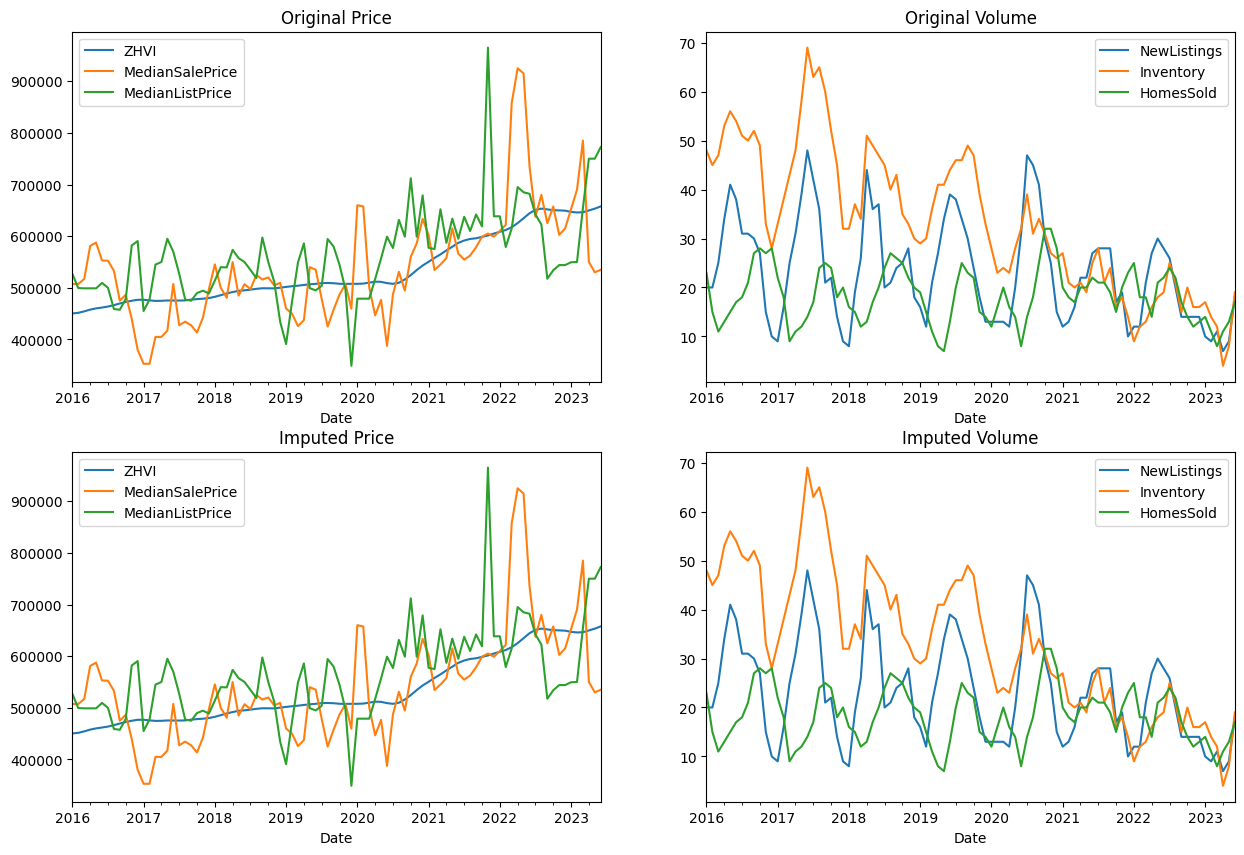

In [38]:
# nothing missing here, just want to check to make sure the data is in the right format
graph_data(df, '10516', df_imputation)

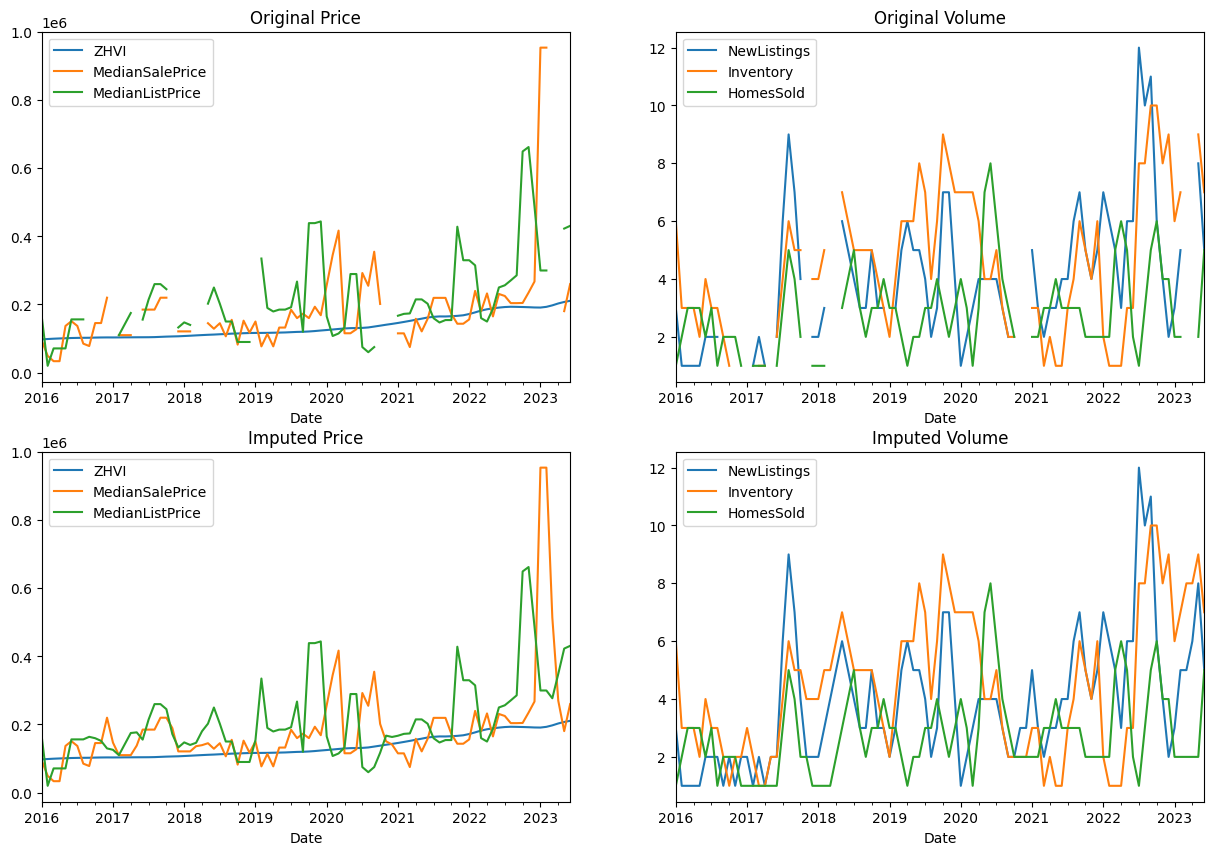

In [42]:
graph_data(df, some_missing.index[0], df_imputation)

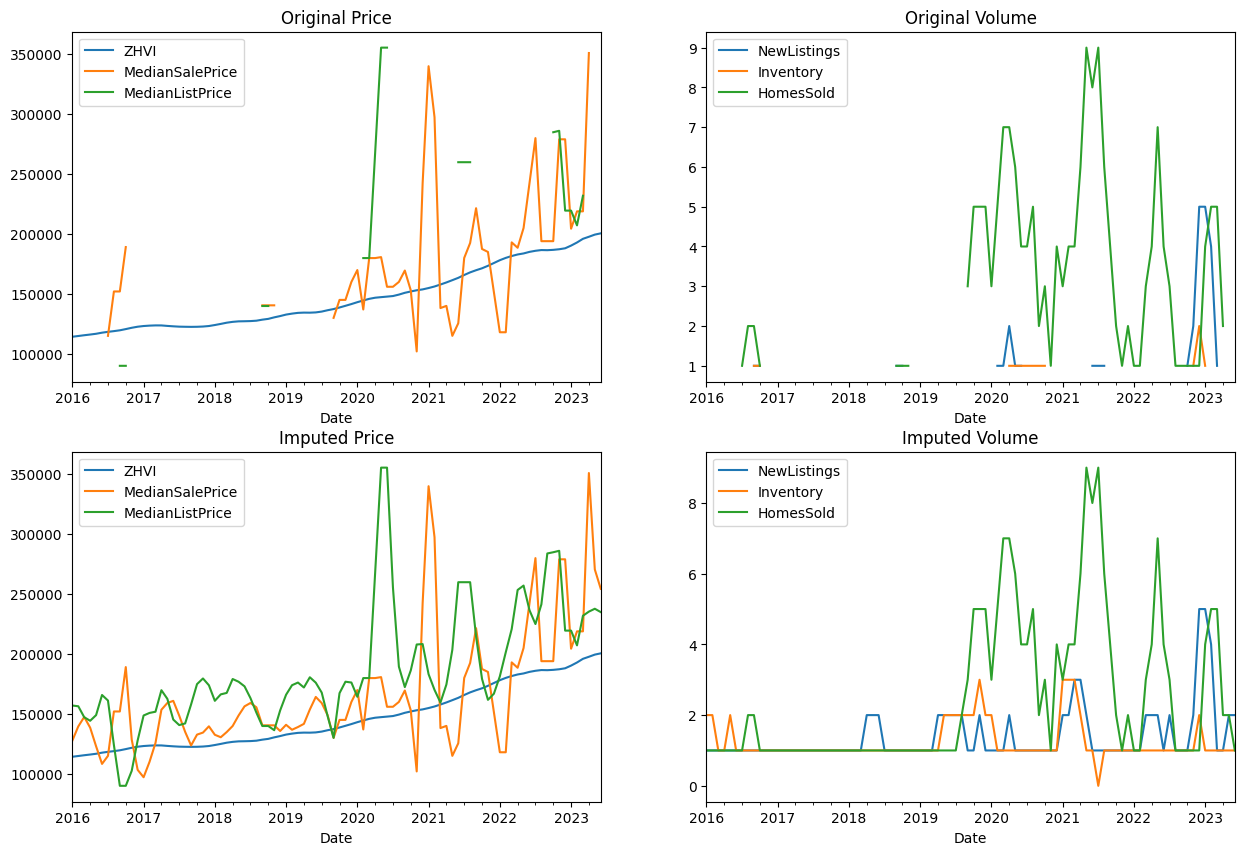

In [41]:
graph_data(df, most_missing.index[2], df_imputation)

In [43]:
df_imputation.to_csv('../../data/clean/Imputed_June23.csv', index= False)